Kernel : Python 3.10.12

source myenv/bin/activate

# I. Librairies & packages

In [1]:
# File system manangement
import os
from os import listdir
import zipfile
from zipfile import ZipFile

import pandas as pd
from PIL import Image
import numpy as np
import io

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

2023-12-19 22:46:41.397459: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 22:46:41.482867: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 22:46:41.966639: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 22:46:41.966681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 22:46:42.045894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Installations

explorer.exe .

In [ ]:
#!pip install Pandas pillow tensorflow pyspark pyarrow

In [2]:
#pip install matplotlib

# II. Extract zip files + define paths

In [2]:
PATH = os.getcwd()

In [9]:
PATH

'/home/denis_linux/Projet8'

In [13]:
PATH_Data = PATH+'/images/fruits-360-original-size/fruits-360-original-size/Test'

In [3]:
PATH_Result = PATH+'/results'

## Open zip files

In [ ]:
with zipfile.ZipFile("Mode_opératoire.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [ ]:
#"C:\Users\denis\Downloads\fruits.zip"

In [ ]:
with zipfile.ZipFile("fruits.zip","r") as zip_ref:
    zip_ref.extractall("images")

# III. Notebook from other

## III.1 Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé **SparkSession**. <br />
<u>Une instance de **SparkSession** est la façon dont Spark exécute les fonctions définies par l’utilisateur <br />
dans l’ensemble du cluster</u>. <u>Une SparkSession correspond toujours à une application Spark</u>.

<u>Ici nous créons une session spark en spécifiant dans l'ordre</u> :
 1. un **nom pour l'application**, qui sera affichée dans l'interface utilisateur Web Spark "**P8**"
 2. que l'application doit s'exécuter **localement**. <br />
   Nous ne définissons pas le nombre de cœurs à utiliser (comme .master('local[4]) pour 4 cœurs à utiliser), <br />
   nous utiliserons donc tous les cœurs disponibles dans notre processeur.<br />
 3. une option de configuration supplémentaire permettant d'utiliser le **format "parquet"** <br />
   que nous utiliserons pour enregistrer et charger le résultat de notre travail.
 4. vouloir **obtenir une session spark** existante ou si aucune n'existe, en créer une nouvelle

In [4]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/12/19 22:49:40 WARN Utils: Your hostname, DESKTOP-Q93CEC6 resolves to a loopback address: 127.0.1.1; using 172.18.84.113 instead (on interface eth0)
23/12/19 22:49:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 22:49:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<u>Nous créons également la variable "**sc**" qui est un **SparkContext** issue de la variable **spark**</u> :

In [5]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [6]:
spark

## III.2 Traitement des données

<u>Dans la suite de notre flux de travail, <br />
nous allons successivement</u> :
1. Préparer nos données
    1. Importer les images dans un dataframe **pandas UDF**
    2. Associer aux images leur **label**
    3. Préprocesser en **redimensionnant nos images pour <br />
       qu'elles soient compatibles avec notre modèle**
2. Préparer notre modèle
    1. Importer le modèle **MobileNetV2**
    2. Créer un **nouveau modèle** dépourvu de la dernière couche de MobileNetV2
3. Définir le processus de chargement des images et l'application <br />
   de leur featurisation à travers l'utilisation de pandas UDF
3. Exécuter les actions d'extraction de features
4. Enregistrer le résultat de nos actions
5. Tester le bon fonctionnement en chargeant les données enregistrées




### III.2.1 Chargement des données

Les images sont chargées au format binaire, ce qui offre, <br />
plus de souplesse dans la façon de prétraiter les images.

Avant de charger les images, nous spécifions que nous voulons charger <br />
uniquement les fichiers dont l'extension est **jpg**.

Nous indiquons également de charger tous les objets possibles contenus <br />
dans les sous-dossiers du dossier communiqué.

In [14]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [15]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------------------------------------------------------+-----------+
|path                                                                                                               |label      |
+-------------------------------------------------------------------------------------------------------------------+-----------+
|file:/home/denis_linux/Projet8/images/fruits-360-original-size/fruits-360-original-size/Test/apple_hit_1/r0_115.jpg|apple_hit_1|
|file:/home/denis_linux/Projet8/images/fruits-360-original-size/fruits-360-original-size/Test/apple_hit_1/r0_119.jpg|apple_hit_1|
|file:/home/denis_linux/Projet8/images/fruits-360-original-size/fruits-360-original-size/Test/apple_hit_1/r0_107.jpg|apple_hit_1|
|file:/hom

### III.7.2 Préparation du modèle

Je vais utiliser la technique du **transfert learning** pour extraire les features des images.<br />
J'ai choisi d'utiliser le modèle **MobileNetV2** pour sa rapidité d'exécution comparée <br />
à d'autres modèles comme *VGG16* par exemple.

Pour en savoir plus sur la conception et le fonctionnement de MobileNetV2, <br />
je vous invite à lire [cet article](https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c).

<u>Voici le schéma de son architecture globale</u> : 

![Architecture de MobileNetV2](img/mobilenetv2_architecture.png)

Il existe une dernière couche qui sert à classer les images <br />
selon 1000 catégories que nous ne voulons pas utiliser.<br />
L'idée dans ce projet est de récupérer le **vecteur de caractéristiques <br />
de dimensions (1,1,1280)** qui servira, plus tard, au travers d'un moteur <br />
de classification à reconnaitre les différents fruits du jeu de données.

Comme d'autres modèles similaires, **MobileNetV2**, lorsqu'on l'utilise <br />
en incluant toutes ses couches, attend obligatoirement des images <br />
de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), <br />
nous devrons simplement les **redimensionner** avant de les confier au modèle.

<u>Dans l'odre</u> :
 1. Nous chargeons le modèle **MobileNetV2** avec les poids **précalculés** <br />
    issus d'**imagenet** et en spécifiant le format de nos images en entrée
 2. Nous créons un nouveau modèle avec:
  - <u>en entrée</u> : l'entrée du modèle MobileNetV2
  - <u>en sortie</u> : l'avant dernière couche du modèle MobileNetV2

In [16]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

### /!\ added step!!

In [23]:
#bc_model_weights = sc.broadcast(model.get_weights())

In [17]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [18]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [19]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [20]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### III.7.3 Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

<u>L'empilement des appels est la suivante</u> :

- Pandas UDF
  - featuriser une série d'images pd.Series
   - prétraiter une image

In [21]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/denis_linux/.local/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### III.7.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), <br />
peuvent rencontrer des erreurs de type Out Of Memory (OOM).<br />
Si vous rencontrez de telles erreurs dans la cellule ci-dessous, <br />
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet <br />
et je laisse donc la commande en commentaire.

In [20]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />
<u>REMARQUE</u> : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter. <br />

Notre jeu de données de **Test** contient **22819 images**. <br />
Cependant, dans l'exécution en mode **local**, <br />
nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [22]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [23]:
print(PATH_Result)

/home/denis_linux/Projet8/results


In [24]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-12-19 22:55:37.786330: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-19 22:55:37.790019: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 22:55:37.836343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 22:55:37.836424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 22:55:37.839934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## III.8 Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [25]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [26]:
df.head()

,path,label,features
0,file:/home/denis_linux/Projet8/images/fruits-3...,apple_hit_1,"[0.2560484, 0.31309468, 1.6202651, 0.0, 0.0, 0..."
1,file:/home/denis_linux/Projet8/images/fruits-3...,apple_hit_1,"[0.28270248, 0.36120322, 1.4489126, 0.0, 0.0, ..."
2,file:/home/denis_linux/Projet8/images/fruits-3...,apple_hit_1,"[0.32698685, 0.8156345, 1.9997269, 0.0, 0.3684..."
3,file:/home/denis_linux/Projet8/images/fruits-3...,apple_hit_1,"[0.002047996, 0.20311466, 0.029865382, 0.0, 0...."
4,file:/home/denis_linux/Projet8/images/fruits-3...,cabbage_white_1,"[0.0, 0.6773124, 3.1746726, 0.0, 0.8204753, 0...."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [27]:
df.loc[0,'features'].shape

(1280,)

In [28]:
df.shape

(3110, 3)

Nous venons de valider le processus sur un jeu de données allégé en local <br />
où nous avons simulé un cluster de machines en répartissant la charge de travail <br />
sur différents cœurs de processeur au sein d'une même machine.

Nous allons maintenant généraliser le processus en déployant notre solution <br />
sur un réel cluster de machines et nous travaillerons désormais sur la totalité <br />
des 22819 images de notre dossier "Test".

# III.9 Dimension reduction (PCA)

In [29]:
type(df)

pandas.core.frame.DataFrame

In [32]:
df.loc[0, 'features']

array([0.0295081 , 0.06816356, 0.        , ..., 1.1162362 , 0.        ,
       0.        ], dtype=float32)

In [30]:
list(df.features)

[array([0.2560484 , 0.31309468, 1.6202651 , ..., 0.        , 0.36857334,
        0.08456384], dtype=float32),
 array([0.28270248, 0.36120322, 1.4489126 , ..., 0.        , 0.0765643 ,
        0.08206628], dtype=float32),
 array([0.32698685, 0.8156345 , 1.9997269 , ..., 0.01647847, 2.025017  ,
        0.        ], dtype=float32),
 array([0.002048  , 0.20311466, 0.02986538, ..., 0.        , 1.4268376 ,
        0.25549495], dtype=float32),
 array([0.        , 0.6773124 , 3.1746726 , ..., 0.        , 0.26732415,
        0.3660047 ], dtype=float32),
 array([0.34845182, 0.02410462, 0.03607604, ..., 0.13520868, 0.        ,
        0.13477619], dtype=float32),
 array([0.5632592 , 0.        , 0.        , ..., 0.05248221, 0.02924546,
        0.19561702], dtype=float32),
 array([0.        , 0.59185535, 1.0169357 , ..., 0.        , 0.12510979,
        0.41609794], dtype=float32),
 array([0.        , 1.7062128 , 1.0365667 , ..., 0.        , 0.00665317,
        0.3838877 ], dtype=float32),
 array([0.

In [31]:
data = pd.DataFrame(data=list(df.features))

In [32]:
data

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0.256048,0.313095,1.620265,0.000000,0.000000,0.000000,0.429533,0.534386,0.070816,0.000000,...,0.000000,0.008497,0.350570,1.016020,0.182234,0.086197,0.000000,0.000000,0.368573,0.084564
1,0.282702,0.361203,1.448913,0.000000,0.000000,0.000000,0.125642,0.246889,0.154094,0.000000,...,0.000000,0.002138,0.055773,1.359653,0.000000,0.000000,0.000000,0.000000,0.076564,0.082066
2,0.326987,0.815634,1.999727,0.000000,0.368489,0.124722,0.410970,0.621060,1.249533,0.000000,...,0.019472,0.000000,0.000000,0.062128,0.583187,0.000000,0.073571,0.016478,2.025017,0.000000
3,0.002048,0.203115,0.029865,0.000000,0.934939,0.259604,2.151520,0.132120,0.341185,0.000000,...,0.106511,0.000000,0.206771,1.832690,0.080604,0.000000,0.025746,0.000000,1.426838,0.255495
4,0.000000,0.677312,3.174673,0.000000,0.820475,0.000000,0.111898,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.045563,0.354571,0.023764,0.000000,0.000000,0.000000,0.267324,0.366005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3105,0.023447,0.000000,0.174765,0.098733,0.496627,0.186800,0.800243,0.453474,0.000000,0.019804,...,0.047874,0.000000,0.171470,0.000000,0.210196,0.000000,0.489971,0.000000,0.160821,0.695029
3106,0.218765,1.487013,0.000000,0.000000,0.009996,0.000000,0.613470,0.004475,0.411604,0.303998,...,0.264009,0.000000,0.339540,1.140097,0.009977,0.000000,0.000000,0.000000,0.001815,0.389690
3107,0.434035,0.666481,0.007399,0.000000,0.028482,0.005150,0.955840,0.589790,0.192424,0.108987,...,0.046523,0.000000,0.512879,1.661525,0.033803,0.058499,0.000000,0.141491,0.049195,0.116647
3108,0.091010,1.073515,0.011462,0.000000,0.000000,0.000000,0.219090,0.132487,0.143879,0.157934,...,0.106750,0.000000,0.022511,1.456795,0.004166,0.013178,0.000000,0.262799,0.040334,0.027107


In [33]:
col = ['col'+str(ele) for ele in data.columns]

In [34]:
data.columns = col

In [35]:
data.to_csv(PATH_Result+'/data.csv', index=False)

In [36]:
from pyspark.ml.feature import RFormula, PCA
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.ml.linalg import Vectors
#from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/denis_linux/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [37]:
data = sqlContext.read.load(PATH_Result+'/data.csv', format='com.databricks.spark.csv', delimiter = ',', header='true', inferSchema='true')

In [38]:
type(data)

pyspark.sql.dataframe.DataFrame

In [20]:
data

DataFrame[col0: double, col1: double, col2: double, col3: double, col4: double, col5: double, col6: double, col7: double, col8: double, col9: double, col10: double, col11: double, col12: double, col13: double, col14: double, col15: double, col16: double, col17: double, col18: double, col19: double, col20: double, col21: double, col22: double, col23: double, col24: double, col25: double, col26: double, col27: double, col28: double, col29: double, col30: double, col31: double, col32: double, col33: double, col34: double, col35: double, col36: double, col37: double, col38: double, col39: double, col40: double, col41: double, col42: double, col43: double, col44: double, col45: double, col46: double, col47: double, col48: double, col49: double, col50: double, col51: double, col52: double, col53: double, col54: double, col55: double, col56: double, col57: double, col58: double, col59: double, col60: double, col61: double, col62: double, col63: double, col64: double, col65: double, col66: dou

In [39]:
data.show()

23/12/19 22:59:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+-----------+------------+-----------+------------+-----------+-----------+-----------+------------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+-----------+----------+-----------+----------+------------+-----------+------------+------------+------------+-----------+----------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+------------+------------+-----------+------------+------------+-----------+-----------+------------+------------+-----------+------------+----------+------------+--------

In [39]:
#dataPCA = PCA(k=20, inputCol=str(data.columns), outputCol="pcaFeatures")
#model = dataPCA.fit(data)

In [44]:
data = RFormula(formula=" ~ {0}".format(" + ".join(data.columns))).fit(data).transform(data)

In [45]:
data

DataFrame[col0: double, col1: double, col2: double, col3: double, col4: double, col5: double, col6: double, col7: double, col8: double, col9: double, col10: double, col11: double, col12: double, col13: double, col14: double, col15: double, col16: double, col17: double, col18: double, col19: double, col20: double, col21: double, col22: double, col23: double, col24: double, col25: double, col26: double, col27: double, col28: double, col29: double, col30: double, col31: double, col32: double, col33: double, col34: double, col35: double, col36: double, col37: double, col38: double, col39: double, col40: double, col41: double, col42: double, col43: double, col44: double, col45: double, col46: double, col47: double, col48: double, col49: double, col50: double, col51: double, col52: double, col53: double, col54: double, col55: double, col56: double, col57: double, col58: double, col59: double, col60: double, col61: double, col62: double, col63: double, col64: double, col65: double, col66: dou

In [56]:
dataPCA = PCA(k=50, inputCol=str(data.columns), outputCol="pcaFeatures")
#model = dataPCA.fit(data)

In [57]:
dataPCA

PCA_fa5c24a7dbcf

In [58]:
dataPCA.setInputCol("features").fit(data).transform(data)

DataFrame[col0: double, col1: double, col2: double, col3: double, col4: double, col5: double, col6: double, col7: double, col8: double, col9: double, col10: double, col11: double, col12: double, col13: double, col14: double, col15: double, col16: double, col17: double, col18: double, col19: double, col20: double, col21: double, col22: double, col23: double, col24: double, col25: double, col26: double, col27: double, col28: double, col29: double, col30: double, col31: double, col32: double, col33: double, col34: double, col35: double, col36: double, col37: double, col38: double, col39: double, col40: double, col41: double, col42: double, col43: double, col44: double, col45: double, col46: double, col47: double, col48: double, col49: double, col50: double, col51: double, col52: double, col53: double, col54: double, col55: double, col56: double, col57: double, col58: double, col59: double, col60: double, col61: double, col62: double, col63: double, col64: double, col65: double, col66: dou

In [59]:
pcaModel = dataPCA.fit(data)

In [60]:
pcaModel.getK

<bound method _PCAParams.getK of PCAModel: uid=PCA_fa5c24a7dbcf, k=50>

In [61]:
pcaModel.explainedVariance

DenseVector([0.145, 0.1151, 0.0739, 0.051, 0.0393, 0.0353, 0.0292, 0.0266, 0.0227, 0.0215, 0.0191, 0.0171, 0.0161, 0.014, 0.0123, 0.0112, 0.0107, 0.0101, 0.0096, 0.009, 0.0084, 0.0072, 0.0069, 0.0068, 0.0066, 0.0063, 0.0059, 0.0056, 0.0052, 0.0051, 0.0047, 0.0045, 0.0043, 0.0041, 0.0039, 0.0038, 0.0035, 0.0035, 0.0033, 0.0032, 0.0031, 0.0029, 0.0029, 0.0029, 0.0027, 0.0027, 0.0026, 0.0025, 0.0025, 0.0024])

In [62]:
cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values

In [65]:
cumValues

array([0.14496152, 0.26010579, 0.33399433, 0.38498762, 0.42427307,
       0.45953656, 0.48877935, 0.51534584, 0.53808798, 0.55953833,
       0.57864177, 0.59577089, 0.61182684, 0.62587166, 0.63814886,
       0.64932957, 0.66007351, 0.6701688 , 0.67979055, 0.68882226,
       0.69717464, 0.7043815 , 0.71132513, 0.71813492, 0.72473668,
       0.73100013, 0.73687409, 0.74249807, 0.74765016, 0.75270351,
       0.75742913, 0.76193018, 0.76620532, 0.77030409, 0.77423166,
       0.7780457 , 0.7815811 , 0.7850439 , 0.78831444, 0.79151691,
       0.79457552, 0.79748775, 0.80039152, 0.80325257, 0.80595553,
       0.80862194, 0.81119549, 0.81371147, 0.81619368, 0.81856836])

Text(0, 0.5, 'cumulative explained variance')

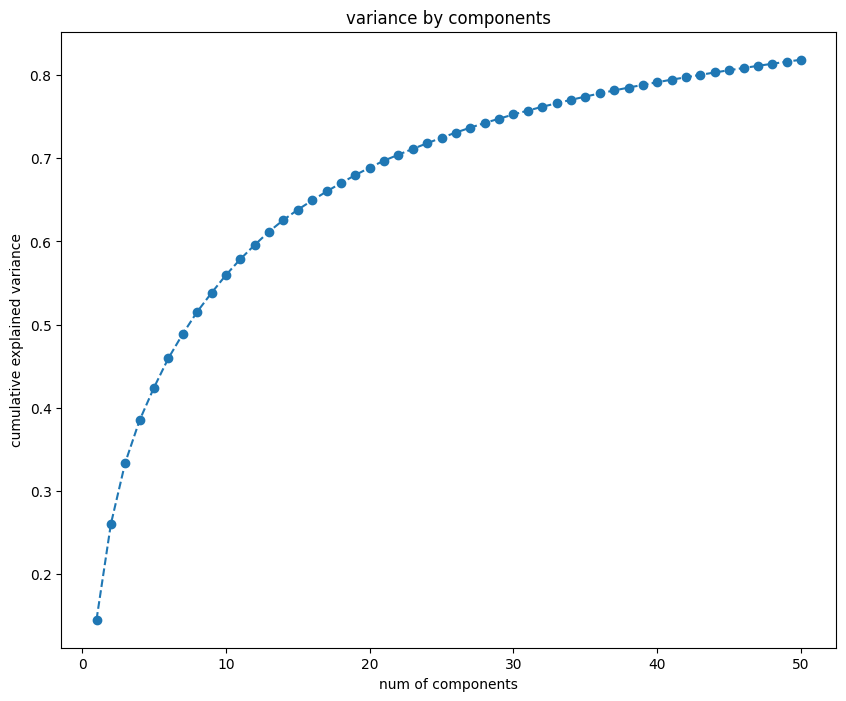

In [64]:
# plot the graph 
plt.figure(figsize=(10,8))
plt.plot(range(1,51), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

In [66]:
pcaModel.setOutputCol("output")

PCAModel: uid=PCA_fa5c24a7dbcf, k=50

In [74]:
data.show()

+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+-----------+------------+-----------+------------+-----------+-----------+-----------+------------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+-----------+----------+-----------+----------+------------+-----------+------------+------------+------------+-----------+----------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+------------+------------+-----------+------------+------------+-----------+-----------+------------+------------+-----------+------------+----------+------------+--------

In [78]:
type(data)

pyspark.sql.dataframe.DataFrame

In [71]:
pcaModel.transform(data).collect()[0].output

23/12/19 23:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1184.7 KiB


DenseVector([5.9039, -1.1812, 3.1791, 1.2583, 4.6347, 7.7544, 1.2125, 0.7788, 2.4571, 3.0454, -1.2335, 7.231, -2.3735, 1.3644, -0.4666, 2.6803, -1.4899, 3.185, 6.2473, -0.0813, 0.6954, -2.0961, -2.5173, -3.1924, 2.0304, -3.3338, 2.9782, 0.6141, 1.0899, -4.7118, -0.4754, 2.9141, 1.0003, -3.0274, 1.1043, -5.3365, 1.641, -1.4532, 3.9913, -0.1755, 1.2879, -1.9505, 0.1623, 0.4077, 0.5754, 1.5942, 2.0863, 1.906, 1.3674, -1.114])

In [83]:
pcaModel.transform(data).collect()[0]

23/12/19 23:51:52 WARN DAGScheduler: Broadcasting large task binary with size 1184.7 KiB


Row(col0=0.2560484, col1=0.31309468, col2=1.6202651, col3=0.0, col4=0.0, col5=0.0, col6=0.42953265, col7=0.5343862, col8=0.070816256, col9=0.0, col10=0.014482089, col11=0.0, col12=0.66053545, col13=0.0, col14=0.007167962, col15=0.0, col16=0.0, col17=0.028196977, col18=0.002917893, col19=0.88812476, col20=0.0, col21=0.6497834, col22=0.06530435, col23=0.0, col24=0.0, col25=0.4045372, col26=0.26150766, col27=0.8898546, col28=0.04275532, col29=0.86082387, col30=0.021956852, col31=0.20436953, col32=0.0, col33=0.76575845, col34=0.0, col35=0.0, col36=0.19276942, col37=1.8019449, col38=0.0026932638, col39=0.0063321735, col40=0.0, col41=0.0, col42=0.05129612, col43=0.44525996, col44=0.0, col45=0.0, col46=1.2412567, col47=0.077988476, col48=1.6895936, col49=0.37707058, col50=0.13805264, col51=0.0, col52=0.032935668, col53=0.0, col54=0.0, col55=1.1557591, col56=0.0, col57=0.02767957, col58=0.11704083, col59=0.0, col60=0.22391646, col61=0.09163514, col62=0.0, col63=0.0, col64=2.1965697, col65=2.06

In [84]:
df_ = pcaModel.transform(data)

In [85]:
type(df_)

pyspark.sql.dataframe.DataFrame

In [86]:
df_.show()

23/12/19 23:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1340.6 KiB


+-----------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+-----------+------------+-----------+------------+-----------+-----------+-----------+------------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+-----------+----------+-----------+----------+------------+-----------+------------+------------+------------+-----------+----------+------------+------------+-----------+-----------+------------+------------+-----------+-----------+------------+-----------+------------+------------+------------+-----------+------------+------------+-----------+-----------+------------+------------+-----------+------------+----------+------------+--------

In [93]:
df_.select('output').collect()

23/12/19 23:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.9 KiB


[Row(output=DenseVector([5.9039, -1.1812, 3.1791, 1.2583, 4.6347, 7.7544, 1.2125, 0.7788, 2.4571, 3.0454, -1.2335, 7.231, -2.3735, 1.3644, -0.4666, 2.6803, -1.4899, 3.185, 6.2473, -0.0813, 0.6954, -2.0961, -2.5173, -3.1924, 2.0304, -3.3338, 2.9782, 0.6141, 1.0899, -4.7118, -0.4754, 2.9141, 1.0003, -3.0274, 1.1043, -5.3365, 1.641, -1.4532, 3.9913, -0.1755, 1.2879, -1.9505, 0.1623, 0.4077, 0.5754, 1.5942, 2.0863, 1.906, 1.3674, -1.114])),
 Row(output=DenseVector([5.9805, -1.0457, 3.2855, 2.1981, 5.2668, 6.8818, 1.2399, 0.9101, 2.8742, 3.2937, -1.1935, 7.5584, -2.387, 1.8732, -0.3728, 3.0613, -1.7163, 3.0228, 6.7755, -0.3373, 1.413, -2.2781, -2.7321, -2.1146, 2.4941, -3.1475, 3.409, 0.4323, 0.2453, -4.2977, -1.1138, 2.6362, 1.1811, -2.9721, 1.3141, -4.9162, 0.8898, -0.8531, 3.7233, -0.4543, 1.8089, -1.5191, 0.1874, 0.4284, -0.3472, 1.6873, 2.5478, 2.2481, 1.0198, -1.2011])),
 Row(output=DenseVector([5.5192, 0.0802, 3.4819, -1.7189, 4.7152, 10.3381, 2.6402, -1.9965, -1.5041, 1.2275, -0.353

In [94]:
df2_ = spark.createDataFrame(df_.select('output').collect(),["features"])

23/12/20 00:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.9 KiB


In [95]:
df2_.show()

23/12/20 00:02:24 WARN TaskSetManager: Stage 90 contains a task of very large size (1413 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|            features|
+--------------------+
|[5.90391424310741...|
|[5.98046812976656...|
|[5.51921343841499...|
|[5.75401218595925...|
|[4.37929899196247...|
|[5.81474863761454...|
|[2.78289860859383...|
|[4.84872296230861...|
|[6.32168568553472...|
|[3.56496298209683...|
|[5.89290958837466...|
|[6.01063705702826...|
|[4.36399019981820...|
|[7.66050250631134...|
|[-1.9003417792054...|
|[-0.2539857466513...|
|[-1.0522429969388...|
|[2.74023549006343...|
|[-5.9411636527642...|
|[-3.9652403899567...|
+--------------------+
only showing top 20 rows



In [98]:
type(df2_)

pyspark.sql.dataframe.DataFrame

from pyspark.ml.functions import vector_to_array
df3_ = df2_.withColumn('features', vector_to_array('features'))

In [99]:
#data.count()

In [100]:
# Save the DataFrame to a Parquet file
parquet_path = PATH_Result+'/myparquet'
df2_.write.parquet(parquet_path)

23/12/20 00:07:10 WARN TaskSetManager: Stage 92 contains a task of very large size (1413 KiB). The maximum recommended task size is 1000 KiB.


In [101]:
# Read the Parquet file to verify
df_read = spark.read.parquet(parquet_path)
df_read.show()

+--------------------+
|            features|
+--------------------+
|[5.90391424310741...|
|[5.98046812976656...|
|[5.51921343841499...|
|[5.75401218595925...|
|[4.37929899196247...|
|[5.81474863761454...|
|[2.78289860859383...|
|[4.84872296230861...|
|[6.32168568553472...|
|[3.56496298209683...|
|[5.89290958837466...|
|[6.01063705702826...|
|[4.36399019981820...|
|[7.66050250631134...|
|[-1.9003417792054...|
|[-0.2539857466513...|
|[-1.0522429969388...|
|[2.74023549006343...|
|[-5.9411636527642...|
|[-3.9652403899567...|
+--------------------+
only showing top 20 rows



In [107]:
type(df_read)

pyspark.sql.dataframe.DataFrame

In [111]:
df_read.collect()[0]

Row(features=DenseVector([5.9039, -1.1812, 3.1791, 1.2583, 4.6347, 7.7544, 1.2125, 0.7788, 2.4571, 3.0454, -1.2335, 7.231, -2.3735, 1.3644, -0.4666, 2.6803, -1.4899, 3.185, 6.2473, -0.0813, 0.6954, -2.0961, -2.5173, -3.1924, 2.0304, -3.3338, 2.9782, 0.6141, 1.0899, -4.7118, -0.4754, 2.9141, 1.0003, -3.0274, 1.1043, -5.3365, 1.641, -1.4532, 3.9913, -0.1755, 1.2879, -1.9505, 0.1623, 0.4077, 0.5754, 1.5942, 2.0863, 1.906, 1.3674, -1.114]))

In [112]:
df_read.collect()[0][0][-1]

-1.1139777150899703